In [1]:
!pip install -U tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [2]:
!mkdir -p /root/.kaggle
!echo '{"username":"davialvb","key":"dc32bb8241bad31c539756dccc6cd16c"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!ls -al *

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
-rw-r--r-- 1 root root 2463365435 Nov 30 20:50 chest-xray-pneumonia.zip

chest_xray:
total 28
drwxr-xr-x 7 root root 4096 Nov 30 20:51 .
drwxr-xr-x 1 root root 4096 Nov 30 20:50 ..
drwxr-xr-x 5 root root 4096 Nov 30 20:50 chest_xray
drwxr-xr-x 3 root root 4096 Nov 30 20:50 __MACOSX
drwxr-xr-x 4 root root 4096 Nov 30 20:50 test
drwxr-xr-x 4 root root 4096 Nov 30 20:50 train
drwxr-xr-x 4 root root 4096 Nov 30 20:51 val

sample_data:
total 55512
drwxr-xr-x 1 root root     4096 Nov 21 16:30 .
drwxr-xr-x 1 root root     4096 Nov 30 20:50 ..
-rwxr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json
-rw-r--r-- 1 root root   301141 Nov 21 16:30 california_housing_test.csv
-rw-r--r-- 1 root root  1706430 Nov 21 16:30 california_housing_train.csv
-rw-r--r-- 1 root root 1828

# Import dependencies

In [3]:
import pandas as pd 
import cv2                 
import numpy as np         
import os          
import skimage as sk       
import scipy
import skimage 
import random
import os
import pathlib
import tensorflow as tf
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import cv2
from random import shuffle
from tqdm import tqdm  
from skimage.transform import resize
from scipy import ndarray
from skimage import transform
from skimage import util
from __future__ import absolute_import, division, print_function, unicode_literals
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

2.0.0


In [4]:
!ls -la chest_xray/

total 28
drwxr-xr-x 7 root root 4096 Nov 30 20:51 .
drwxr-xr-x 1 root root 4096 Nov 30 20:50 ..
drwxr-xr-x 5 root root 4096 Nov 30 20:50 chest_xray
drwxr-xr-x 3 root root 4096 Nov 30 20:50 __MACOSX
drwxr-xr-x 4 root root 4096 Nov 30 20:50 test
drwxr-xr-x 4 root root 4096 Nov 30 20:50 train
drwxr-xr-x 4 root root 4096 Nov 30 20:51 val


In [0]:
# Create variables with path
TRAIN_PATH = pathlib.Path('./chest_xray/train/')
TEST_PATH = pathlib.Path('./chest_xray/test/')
VAL_PATH = pathlib.Path('./chest_xray/val')

## Number of samples

In [6]:
train_count = len(list(TRAIN_PATH.glob('*/*.jpeg')))
test_count = len(list(TEST_PATH.glob('*/*.jpeg')))
val_count = len(list(VAL_PATH.glob('*/*.jpeg')))
train_count, test_count, val_count

(5216, 624, 16)


## Normal Pacient vs Pacient with Pneumonia

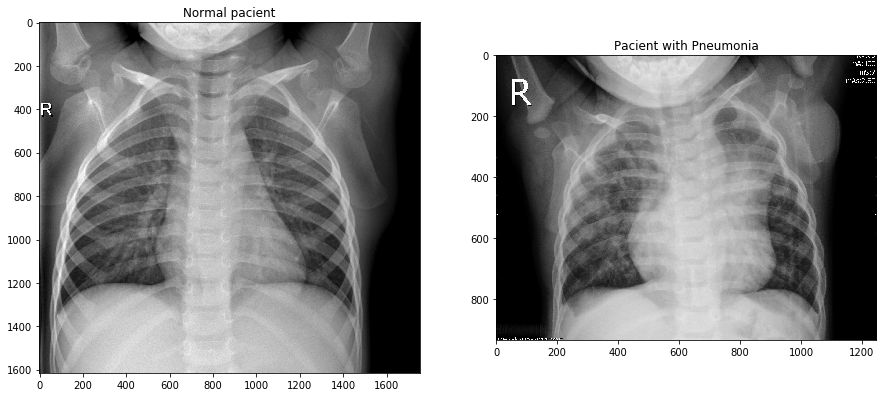

In [7]:
normal_files = list(TRAIN_PATH.glob('NORMAL/*'))
pneumonia_files = list(TRAIN_PATH.glob('PNEUMONIA/*'))

normal_img = cv2.imread(str(normal_files[2]))
pneumonia_img = cv2.imread(str(pneumonia_files[2]))

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Normal pacient')
ax2 = fig.add_subplot(222)
ax2.title.set_text('Pacient with Pneumonia')
ax1.imshow(normal_img)
ax2.imshow(pneumonia_img)

## Create dataset of the file paths

In [8]:
train_ds = tf.data.Dataset.list_files(str(TRAIN_PATH/'*/*'))

for f in train_ds.take(5):
    print(f.numpy())

b'chest_xray/train/PNEUMONIA/person1274_bacteria_3235.jpeg'
b'chest_xray/train/PNEUMONIA/person27_bacteria_136.jpeg'
b'chest_xray/train/PNEUMONIA/person1320_bacteria_3352.jpeg'
b'chest_xray/train/PNEUMONIA/person1144_bacteria_3089.jpeg'
b'chest_xray/train/PNEUMONIA/person1883_bacteria_4769.jpeg'


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  1
2.0.0


## Create dataset of the file paths

In [10]:
CLASS_NAMES = np.array([item.name for item in TRAIN_PATH.glob('*')])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(train_count/BATCH_SIZE)

In [0]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, '/')
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label
    
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

labeled_ds = train_ds.map(process_path, AUTOTUNE)

for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

## Dataset Visualization

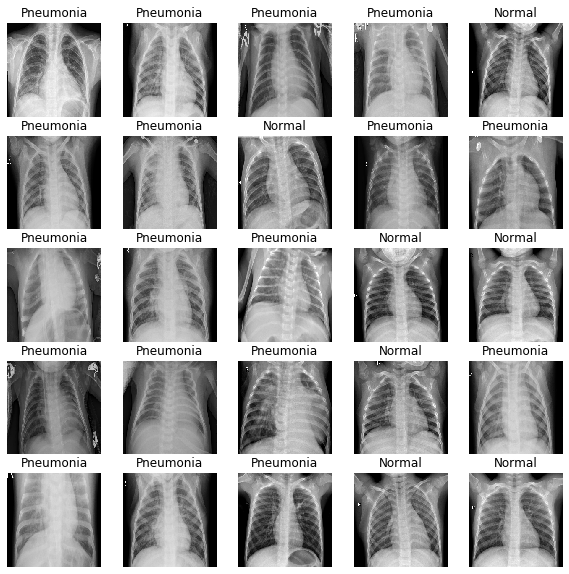

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Train Dataset Label Count

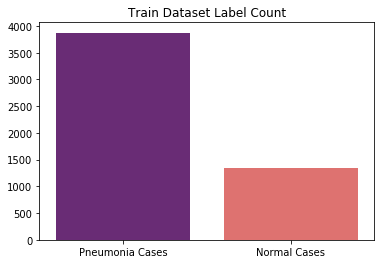

(3875, 1341)

In [17]:
import seaborn as sns

pneumonia_count = len(list(TRAIN_PATH.glob("PNEUMONIA/*")))
normal_count = len(list(TRAIN_PATH.glob("NORMAL/*")))

sns.barplot(x=['Pneumonia Cases', 'Normal Cases'], y=[pneumonia_count, normal_count], palette='magma')
plt.title('Train Dataset Label Count')
plt.show()
pneumonia_count, normal_count

## Test Dataset Label Count

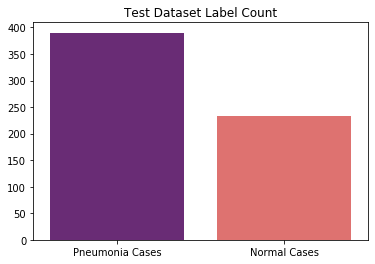

(390, 234)

In [18]:
test_pneumonia_count = len(list(TEST_PATH.glob("PNEUMONIA/*")))
test_normal_count = len(list(TEST_PATH.glob("NORMAL/*")))

sns.barplot(x=['Pneumonia Cases', 'Normal Cases'], y=[test_pneumonia_count, test_normal_count], palette='magma')
plt.title('Test Dataset Label Count')
plt.show()
test_pneumonia_count, test_normal_count

## Deep Learning Model Architecture

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


batch_size = 32
epochs = 5
IMG_HEIGHT = 64
IMG_WIDTH = 64

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(pool_size = (2, 2)),
        Dropout(0.2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size = (2, 2)),
        # Conv2D(64, 3, padding='same', activation='relu'),
        # MaxPooling2D(),
        # Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])  
    return model

# def create_model():
#     model = Sequential([
#         Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#         MaxPooling2D(),
#         Dropout(0.2),
#         Conv2D(32, 3, padding='same', activation='relu'),
#         MaxPooling2D(),
#         Conv2D(64, 3, padding='same', activation='relu'),
#         MaxPooling2D(),
#         Dropout(0.2),
#         Flatten(),
#         Dense(512, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])  
#     return model


model = create_model()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

## Data generators

In [0]:
def train_generator(image_size, batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        # rotation_range=30,
        # width_shift_range=25,
        # height_shift_range=25,
        zoom_range=0.2,
        # brightness_range=(0.8, 1.2),
        shear_range=0.2,
        fill_mode = "constant",
        horizontal_flip=True,
        # vertical_flip=True,
        # cval=0
    )
    data_generator = datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary'
        )
    return data_generator

In [0]:
def validation_generator(image_size, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)
    data_generator = datagen.flow_from_directory(
        VAL_PATH,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')
    return data_generator     

In [0]:
def test_generator(image_size, batch_size=32, shuffle=False):
    datagen = ImageDataGenerator(rescale=1./255)
    data_generator = datagen.flow_from_directory(
        TEST_PATH,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=shuffle,
        class_mode='binary')
    return data_generator

In [31]:
train_data_generator = train_generator(IMG_HEIGHT)
test_data_generator = test_generator(IMG_HEIGHT)
val_data_generator = validation_generator(IMG_HEIGHT)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Number of samples

In [24]:
train_pneumonia_count = len(list(TRAIN_PATH.glob("PNEUMONIA/*")))
train_normal_count = len(list(TRAIN_PATH.glob("NORMAL/*")))

test_pneumonia_count = len(list(TEST_PATH.glob("PNEUMONIA/*")))
test_normal_count = len(list(TEST_PATH.glob("NORMAL/*")))

val_pneumonia_count = len(list(VAL_PATH.glob("PNEUMONIA/*")))
val_normal_count = len(list(VAL_PATH.glob("NORMAL/*")))

train_pneumonia_count, test_pneumonia_count, val_pneumonia_count

(3875, 390, 8)

## Training Step

In [38]:
# import tensorflow.compat.v1 as tfcompat
# sess = tfcompat.Session(config=tfcompat.ConfigProto(log_device_placement=True))
print(tf.config.experimental.list_physical_devices('GPU'))

batch_size = 32
epochs = 10
total_train = train_pneumonia_count + normal_count
total_test = test_pneumonia_count + test_normal_count
total_val = val_pneumonia_count + val_normal_count
steps = total_train // batch_size
# print(total_val // batch_size)

with tf.device('/GPU:0'):
    history = model.fit_generator(
        train_data_generator,
        steps_per_epoch=steps,
        epochs=epochs,
        validation_data=val_data_generator,
        validation_steps=624
    )

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/10
163/163 [==============================] - 190s 1s/step - loss: 0.2373 - accuracy: 0.9007 - val_loss: 0.3507 - val_accuracy: 0.9375
Epoch 2/10
163/163 [==============================] - 185s 1s/step - loss: 0.1963 - accuracy: 0.9222 - val_loss: 0.3259 - val_accuracy: 0.9375
Epoch 3/10
163/163 [==============================] - 186s 1s/step - loss: 0.1819 - accuracy: 0.9264 - val_loss: 0.3025 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 186s 1s/step - loss: 0.1720 - accuracy: 0.9298 - val_loss: 0.5962 - val_accuracy: 0.6875
Epoch 5/10
163/163 [==============================] - 186s 1s/step - loss: 0.1657 - accuracy: 0.9344 - val_loss: 0.3168 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 185s 1s/step - loss: 0.1554 - accuracy: 0.9354 - val_loss: 0.4064 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 186s 1s/step - loss: 

## History Visualization

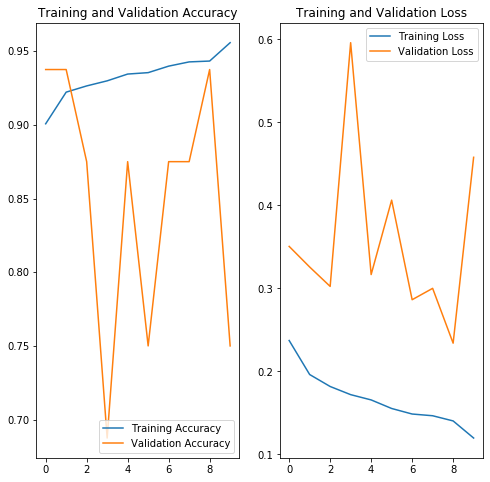

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## The graph is not much conclusive because the validation set does not have a significant number of samples


## Test Evaluation

In [66]:
test_loss, test_score = model.evaluate_generator(test_data_generator, steps=test_count // batch_size + 1)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

Loss on test set:  0.31077142744325104
Accuracy on test set:  0.8894231


In [0]:
y_pred = model.predict_generator(test_data_generator, steps=test_count // batch_size + 1)

In [0]:
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[12,8])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

## Normalized Confusion Matrix

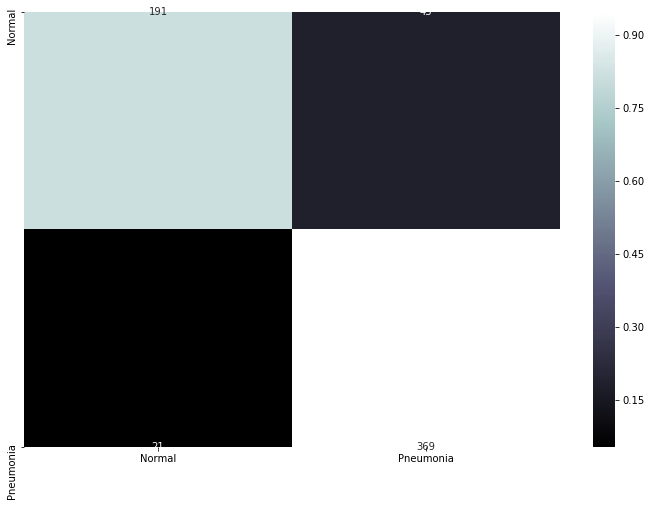

In [89]:
threshold = 0.7
discrete_pred = [1 if pred > threshold else 0 for pred in y_pred]
cm = confusion_matrix(test_data_generator.classes, discrete_pred)
plot_confusion_matrix(cm, ['Normal', 'Pneumonia'])

## Classification Report


In [98]:
from sklearn.metrics import classification_report

print(classification_report(test_data_generator.classes, discrete_pred, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.90      0.82      0.86       234
   Pneumonia       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624

